## CUNY 620 Final Proposal: Sentiment and Network Analyses of Reddit Comments

#### Team 2: Pavan Akula, Nathan (Seoungyoon) Lim, Christophe Hunt, Joel Park, Ilya Kats

**Objective:** In our final project we attempt to evaluate if sentiment influences features of a social network. This allows us to utilize both areas covered by the class - text processing and network analysis - and may yield interesting findings.

For this project we will be looking at discussions featured on Reddit (http://www.reddit.com). Reddit is a social aggregation and discussion website. As of 2017, Reddit had 542 million monthly visitors, ranking #4 most visited website in U.S. and #9 in the world. It allows users to share content with ability to have other users comment on it. We will evaluate social network of Reddit commenters (also known as redditors) and sentiment of comments themselves.

We have chosen a single discussion from the AskReddit subreddit. Discussion is titled "*What is the strongest opinion you hold?*" It was extracted from the data saved on Kaggle covering comments made in May 2015 (https://www.kaggle.com/reddit/reddit-comments-may-2015). Our data set contains 24,134 comments. In addition to the large number of comments, we chose this discussion because the topic may encourage both negative and positive responses (as opposed to a subreddit dedicated to Pres. Trump which is likely to be mostly negative). Kaggle was selected as data source in order to maximize the time we have to analyze it (rather than spending time scraping current data).

Discussion thread being analyzed:
https://www.reddit.com/r/AskReddit/comments/36959m/what_is_the_strongest_opinion_you_hold/

![Reddit](https://assets.ifttt.com/images/channels/1352860597/icons/on_color_small.png)

### DATA IMPORT

In [2]:
# Load libraries
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import networkx as nx
import operator
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer

C:\ProgramData\Anaconda2\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
# Define function that would create a sorted list, from highest to lowest
# This function was taken from page 47 from "Social Network Analysis for Startups".

def sorted_map(map):
    ms = sorted(map.iteritems(), key=lambda (k,v): (-v,k)) 
    return ms

In [4]:
# Retrieve data from the database
sql_con = pymysql.connect(host='104.196.212.179', port=3306, 
                          user='root', passwd='data620pw',
                          db='reddit')

reddit = pd.read_sql('SELECT DISTINCT author, responder, COUNT(1) as weight FROM comments '
                     'GROUP BY author, responder '
                     'HAVING author<>"[deleted]" AND responder<>"[deleted]";', con=sql_con)

reddit_comment = pd.read_sql('SELECT * from comments;', con=sql_con)


# Import users with centrality measures previously calculated
# Just so we don't have to wait for them every time
users = pd.read_sql('SELECT username, betweenness, degree FROM users', con=sql_con)
 
sql_con.close()

In [5]:
# Data test
reddit.loc[0:5]

,author,responder,weight
0,---DevilsAdvocate---,dannybtw,1
1,---DevilsAdvocate---,ThisFreaknGuy,2
2,-Covariance,DomeSlave,1
3,-Mountain-King-,ASK_ABOUT_STEELBEAMS,3
4,-Mountain-King-,AvoidNoiderman,2
5,-Mountain-King-,Bigfrostynugs,1


![Reddit](https://assets.ifttt.com/images/channels/1352860597/icons/on_color_small.png)

### BUILDING NETWORK GRAPH

In [6]:
# Initialize graph
G = nx.Graph()

# Add nodes
nodes = set(reddit.loc[:, "author"])
nodes.union(set(reddit.loc[:, "responder"]))
nodes = list(nodes)
nodes
G.add_nodes_from(nodes)

# Add edges with weights
# Weight is equal to number of interactions between users
#G.add_edges_from([tuple(x) for x in reddit.loc[:, "author":"responder"].values])
G.add_weighted_edges_from([tuple(x) for x in reddit.values])

In [7]:
nx.number_of_nodes(G)

10233

Let's confirm that the graph is fully connected.

In [8]:
nx.number_connected_components(G)

129

In [9]:
# Ten largest subgraphs
[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)[0:10]]

[9928, 9, 6, 5, 5, 5, 5, 5, 4, 4]

The graph is not fully connected. Most likely this is due to deleted user accounts that connected islands consisting of just a few nodes to the main subgraph. Let's remove all small islands and concentrate on the main subgraph.

In [10]:
# Select the largest connected subgraph
G = max(nx.connected_component_subgraphs(G), key=len)
G.number_of_nodes()

9928

Initially, we considered trimming the graph. For example, removing nodes with only 1 or 2 degrees. However, considering that we are dealing with online forum, there will be a significant number of users who only responded once to one comment. These leaves influence centralities of connected nodes and therefore are necessary for our analysis.

In [11]:
# Trim the graph removing any nodes with less than 3 degrees
# remove = [node for node,degree in G.degree().items() if degree < 3]
#G.remove_nodes_from(remove)
#G.number_of_nodes()

Let's get a few other general descriptors of the graph.

In [11]:
# Diameter of the graph
# Takes some time to calculate
nx.diameter(G)

16

In [12]:
# Average shortest path
# Takes some time to calculate
nx.average_shortest_path_length(G, weight='weight')

5.211905025136356

In [12]:
# Top 10 edges by weight
print '%-25s %-25s %-25s' % ('User 1', 'User 2', 'Weight')
print '%-25s %-25s %-25s' % ('----------', '----------', '----------')
for s, t, w in sorted(G.edges(data=True), key=lambda (source,target,data): data['weight'], reverse=True)[0:10]:
    print '%-25s %-25s %-25s' % (s, t, w)

User 1                    User 2                    Weight                   
----------                ----------                ----------               
isthisatrick              uber_kitty                {'weight': 21L}          
Rich700000000000          Rich700000000000          {'weight': 20L}          
Fabius0                   jama211                   {'weight': 17L}          
uber_kitty                DukePristine              {'weight': 15L}          
PsychoPhilosopher         0therworldly              {'weight': 14L}          
jama211                   crazymuffin147            {'weight': 13L}          
-TheCabbageMerchant-      escalat0r                 {'weight': 13L}          
StrawberryMeringue        averysadgirl              {'weight': 10L}          
Taakbiiir                 Mkins                     {'weight': 9L}           
Trevmiester               onioning                  {'weight': 9L}           


Edge weight is the frequency of communication/commenting between two users. It looks like user *Rich700000000000* comments on his own comments relatively often.

In [13]:
'''
The following code was used to calculate centralities during first run
Betweenness centrality takes a long time to calculate 
As such we use saved values for further analysis

# Calculate betweenness centrality
centr_bw = nx.betweenness_centrality(G, weight='weight')

# Calculate degree centrality
centr_deg = nx.degree_centrality(G)
'''

users[0:25]

,username,betweenness,degree
0,CDC_,0.087609,0.035560
1,corby315,0.074198,0.023471
2,fundygud,0.051563,0.020248
3,Lemonaxe,0.049766,0.021557
4,bazzil350,0.049644,0.019845
5,hawkish25,0.049423,0.017125
6,Supersoakthatho,0.048042,0.017729
7,FenrisCain,0.046511,0.018535
8,ohitsali,0.045828,0.018535
9,mstrdpncks,0.045789,0.017528


Here is the full network graph generated in Gephi.

![Full Graph](https://raw.githubusercontent.com/ilyakats/CUNY-DATA620/master/Team-Final/Final-Project/full-graph-gephi.png)

With close to 10,000 nodes the graph is too busy to decipher. We can note that even though there is a large number of long tentacles, the maximum distances between any two nodes is 16. There is a lot of interconnectedness in the hairball center.

Let's look at one user. **Bt1222** is in the top 20 list for degree centrality, but he or she just misses the top 20 list for betweenness centrality.

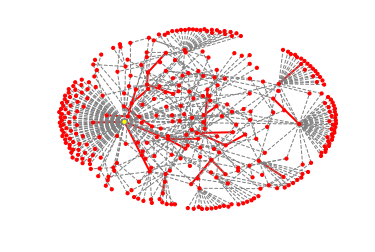

In [14]:
main = 'Bt1222'

# Select neighbors and neighbors of neighbors
subG = G.neighbors(main)
n_list = subG
for n in subG:
    n_list = n_list + G.neighbors(n)
n_list = list(set(n_list))
n_list.append(main)

# Isolate the subnetwork
subG = G.subgraph(n_list)

# Get color map
colormap =[]
for n in subG.nodes():
    if n==main:
        colormap.append('yellow')
    else:
        colormap.append('red')
     
# Separate edges by weight - 1 and more than 1
elarge=[(u,v) for (u,v,d) in subG.edges(data=True) if d['weight']>1]
esmall=[(u,v) for (u,v,d) in subG.edges(data=True) if d['weight']==1]

# Layout
pos=nx.spring_layout(subG)

# Draw nodes
nx.draw_networkx_nodes(subG,pos,node_color=colormap,node_size=10)

# Draw edges
nx.draw_networkx_edges(subG, pos, edgelist=elarge, width=2, edge_color='r')
nx.draw_networkx_edges(subG, pos, edgelist=esmall, width=1, edge_color='grey', style='dashed')

plt.axis('off')
plt.show()

User **Bt1222** is highlighted in yellow. Dashed grey edges are just a single interaction between users. Solid red edges are multiple (2 or more) interactions.

In [15]:
'''
The following code was used to combine centralities into a single data frame
Since the values were saved there is no need to run it

# Combine betweenness and degree centralities into a single data frame

df1 = pd.DataFrame(list(centr_bw.items()), columns=['User', 'Betweenness'])
df2 = pd.DataFrame(list(centr_deg.items()), columns=['User', 'Degree'])
users = df1.join(df2.set_index('User'), on='User')
users.sort_values(['Betweenness', 'Degree'], ascending = False, inplace=True)
'''

users[0:5]

,username,betweenness,degree
0,CDC_,0.087609,0.035560
1,corby315,0.074198,0.023471
2,fundygud,0.051563,0.020248
3,Lemonaxe,0.049766,0.021557
4,bazzil350,0.049644,0.019845


![Reddit](https://assets.ifttt.com/images/channels/1352860597/icons/on_color_small.png)

### SENTIMENT ANALYSIS


In [16]:
''' 
The code below was used to calculate sentiment scores 
For speed of retrieval the values were saved in the database

sid = SentimentIntensityAnalyzer()

child_comment = pd.DataFrame()

for i in range(len(reddit_comment)):
    # Get sentiment scores for parent and comments
    stats_parent = sid.polarity_scores(reddit_comment['comment_parent'][i])
    stats_child = sid.polarity_scores(reddit_comment['comment_child'][i])
    # Select only negative, neutral and positive scores, do not select compound
    stats_parent_sub = dict((k, stats_parent[k]) for k in ('neg', 'neu', 'pos'))
    stats_child_sub = dict((k, stats_child[k]) for k in ('neg', 'neu', 'pos'))
    # Select prevalent sentiment
    reddit_comment.ix[i, 'sentiment_parent'] = max(stats_parent_sub.iteritems(), key=operator.itemgetter(1))[0]
    reddit_comment.ix[i, 'sentiment_child'] = max(stats_child_sub.iteritems(), key=operator.itemgetter(1))[0]
    # Add child scores to data frame
    child_comment = child_comment.append(stats_child, ignore_index=True)

sentiment = pd.concat([reddit_comment, child_comment], axis=1)
'''

# Retrieve sentiment data from the database
sql_con = pymysql.connect(host='104.196.212.179', port=3306, 
                          user='root', passwd='data620pw',
                          db='reddit')
sentiment = pd.read_sql('SELECT id, author, responder, comment_child AS comment, sentiment_child AS sentiment, '
                        'score_compound AS compound, score_neg AS neg, score_neu AS neu, score_pos AS pos '
                        'FROM comments;', con=sql_con)
sql_con.close()

sentiment[0:5]

,id,author,responder,comment,sentiment,compound,neg,neu,pos
0,1320251,redditminus,Wheeeler,With face herpes,neu,0.0000,0.000,1.000,0.000
1,1320252,redditminus,corby315,Unfortunately it's the kids that end up gettin...,neu,-0.6597,0.403,0.597,0.000
2,1320253,redditminus,Theemuts,"Nah man, freedom of choice and fuck all conseq...",neu,0.3549,0.213,0.557,0.230
3,1320254,redditminus,phuicy,"They only real solution is education, because ...",neu,-0.2263,0.173,0.703,0.124
4,1320255,redditminus,qwerty12qwerty,Heard a good quote a few years back in Governm...,neu,0.8555,0.070,0.704,0.226


Let's look at the top 10 most negative and most positive comments.

In [17]:
# Top 10 negative comments
sentiment.sort_values(['compound'], ascending = True)[0:10]

,id,author,responder,comment,sentiment,compound,neg,neu,pos
21099,1362638,illTwinkleYourStar,AppleCoreThing,"I agree with most of this comment, about the p...",neu,-0.9990,0.312,0.591,0.097
14532,1345163,kwhitegocubs,toThe9thPower,"&gt; Revenge does not unrape the raped, resurr...",neu,-0.9990,0.346,0.594,0.060
4840,1328721,SnakeHelah,maypolecrup,&gt; I don't understand the now rising and pop...,neu,-0.9989,0.259,0.639,0.102
8316,1334623,StraightTalkAdvice,digiacom,"First, [H.L. Mencken](http://grammar.about.com...",neu,-0.9988,0.350,0.571,0.079
23507,1395865,PM_Tits_4_LifeMottos,Pixiepup,"I'm trying to feel you here, but things like ""...",neu,-0.9987,0.374,0.554,0.072
21301,1363913,Altered_Amiba,besjbo,&gt;But you can't prove those are the same peo...,neu,-0.9986,0.170,0.732,0.098
20776,1361273,Altered_Amiba,besjbo,&gt;The group itself isn't that way and the wh...,neu,-0.9983,0.175,0.754,0.071
3144,1325119,BillMaher4President,machenise,There are actually some pretty good arguments ...,neu,-0.9983,0.387,0.548,0.065
21141,1362843,besjbo,Altered_Amiba,&gt;I wasn't trying to say that everyone who s...,neu,-0.9983,0.181,0.753,0.067
20514,1360148,besjbo,Altered_Amiba,&gt;Will me finding one example of a person em...,neu,-0.9983,0.198,0.728,0.074


In [18]:
# Most negative comment
comm = sentiment.sort_values(['compound'], ascending = True)[0:1]['comment']
print str(comm.values.flatten())

[ "I agree with most of this comment, about the problem of feminism being a white middle class movement definitely, and modern feminists need to work to combat that.\r\r\n\r\r\nYou're right that a study on false rape accusations is hard to conduct. But I find your comment about the many men whose lives have been ruined by false rape accusations a little strange, when the number of women and men whose lives have been ruined by actual rape is a much more statistically significant problem. \r\r\n\r\r\nI'm not dismissing false rape accusations, but they are notoriously over-represented in the media and all studies (admittedly never going to be perfect studies) have shown them to be extremely fringe in the face of actual rape cases. The sequence of events following a rape accusation are so unpleasant to make false accusations less appealing. \r\r\n\r\r\nFrom [here] (http://www.shakesville.com/2005/12/dont-just-blame-victim-prosecute-her.html) (and admittedly empassioned article)\r\r\n\r\r\n

In [19]:
# Top 10 positive comments
sentiment.sort_values(['compound'], ascending = False)[0:10]

,id,author,responder,comment,sentiment,compound,neg,neu,pos
22830,1379322,bulldoozer,CeasarTheFirst,I'm not screaming rhetoric. You implied that m...,neu,0.9990,0.071,0.729,0.201
21864,1368247,kingphysics,0therworldly,&gt; I'm only going to start my undergrad Phys...,neu,0.9977,0.057,0.787,0.156
623,1321385,MeowMixSong,LadyKa,"Hard-core, willfully blind, forcing-their-view...",neu,0.9975,0.020,0.759,0.220
21633,1366494,GMDev,mrgud69,I absolutely understand where you're coming fr...,neu,0.9975,0.062,0.689,0.249
18723,1353881,franklymydeer,lsdmthcosmos,"Absolutely, you hit it spot on about the gradi...",neu,0.9973,0.052,0.774,0.174
16693,1349343,Joshoowuh,I_love_propofol,I'm a doctor in the UK. I believe that healthc...,neu,0.9969,0.056,0.778,0.166
20773,1361267,Saytahri,___OccamsChainsaw___,"&gt; Yes I would have, my 2nd example was an e...",neu,0.9968,0.070,0.665,0.265
24073,1659093,PsychoPhilosopher,0therworldly,Nice list. Would've been more constructive to ...,neu,0.9964,0.087,0.730,0.184
20791,1361344,steavoh,lessmiserables,It's one of the issues I do have with conserva...,neu,0.9961,0.029,0.785,0.187
8506,1334955,Catatonic27,happybadger,We're in a transitional era when it comes to h...,neu,0.9959,0.034,0.821,0.145


In [20]:
# Most positive comment
comm = sentiment.sort_values(['compound'], ascending = False)[0:1]['comment']
print str(comm.values.flatten())

[ 'I\'m not screaming rhetoric. You implied that my intentions we\'re naive and unfounded. I don\'t have all of the answers, no one does. Even if I attempted to answer all of them, there\'s a sound argument against them. You\'re right it\'s not black and white, however, neither is the solution to this. \r\r\n \r\r\nCapitalism is not a long-term sustainable solution, much in the same way communism is not a good conductor of progress/innovation. The nature of both systems lead to failure. \r\r\n \r\r\nCapitalism in the US and abroad has lasted as long as it has because there is a mix of socialism in there; obviously, moreso in the EU than in the US, but it provides a level of sustainability to society. The spoils (money) generated by a capitalist society are partially spread to everyone. In a way one could argue that everyone played a part in everyone\'s success, because things happened the way they did. \r\r\n \r\r\nCapitalism fails in that it\'s not the real system, it\'s just somewhat

Looking through the lists above we can see that sentiment analysis is not always straight-forward. Comments with the highest compound scores (the most positive ones) have actually relatively low positive scores, but they also have very low negative scores and high neutral scores, which increases compound scores. Let's look at pure positive or negative scores.

In [21]:
# Top 10 negative comments
sentiment.sort_values(['neg'], ascending = False)[0:10]

,id,author,responder,comment,sentiment,compound,neg,neu,pos
1651,1322940,PM_Tits_4_LifeMottos,mivipa,I disagree.,neg,-0.3818,1.0,0.0,0.0
10862,1338623,MrConfucius,BuckYouFungie,No.,neg,-0.2960,1.0,0.0,0.0
2210,1323695,smileedude,aeternitatisdaedalus,WRONG,neg,-0.4767,1.0,0.0,0.0
22654,1376050,soloesliber,megaRXB,No.,neg,-0.2960,1.0,0.0,0.0
7399,1333126,TheMile,thegreatestprime,Disagree.,neg,-0.3818,1.0,0.0,0.0
573,1321301,spookyb0ss,kevo7777,bullshit.,neg,-0.5859,1.0,0.0,0.0
3404,1326095,killminusnine,Rcmike1234,:(,neg,-0.4404,1.0,0.0,0.0
20737,1361118,barbiewannabe23,SeaOfAnarchy,sorry,neg,-0.0772,1.0,0.0,0.0
16404,1348732,Odd_craving,Robtonight,No.,neg,-0.2960,1.0,0.0,0.0
20528,1360203,[deleted],PMME_YOUR_TITS_WOMAN,Wrong.,neg,-0.4767,1.0,0.0,0.0


In [22]:
# Top 10 positive comments
sentiment.sort_values(['pos'], ascending = False)[0:10]

,id,author,responder,comment,sentiment,compound,neg,neu,pos
17763,1351540,ADubs62,Executiveabsurdities,Yep.,pos,0.2960,0.0,0.0,1.0
22932,1380907,Stinkybelly,saddstar,Agreed.,pos,0.2732,0.0,0.0,1.0
23446,1394422,05banks,3jt,Congratulations.,pos,0.5994,0.0,0.0,1.0
3700,1326708,xxbearillaxx,phuicy,:)\r\r\n,pos,0.4588,0.0,0.0,1.0
2524,1324025,corby315,thegreatestprime,Agree.,pos,0.3612,0.0,0.0,1.0
6958,1332102,rgonzal,soggybooty92,LOL \r\r\n\r\r\nU R FUNNY,pos,0.6908,0.0,0.0,1.0
5923,1330412,barassmonkey17,crazy_weird_rabbit,Lol,pos,0.4215,0.0,0.0,1.0
21247,1363544,StandardFiend,fusterclux,lmao,pos,0.5994,0.0,0.0,1.0
843,1321845,bazzil350,bigblah,Agreed.,pos,0.2732,0.0,0.0,1.0
11559,1339834,-Mountain-King-,Dsiroon37,yes.,pos,0.4019,0.0,0.0,1.0


These are easier to interpret than the long comments with several paragraphs.

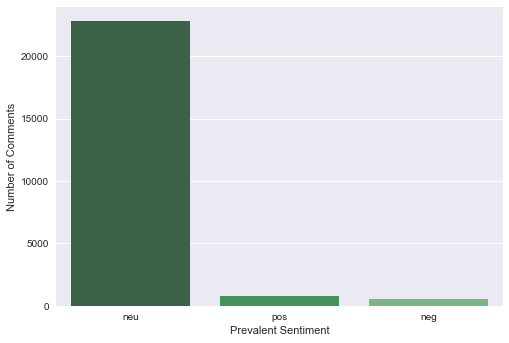

In [23]:
import seaborn as sns
sns.countplot(x="sentiment", data = sentiment, palette="Greens_d");
plt.ylabel('Number of Comments')
plt.xlabel('Prevalent Sentiment')
plt.show()

![Reddit](https://assets.ifttt.com/images/channels/1352860597/icons/on_color_small.png)

### SENTIMENT SCORE AND CENTRALITY CORRELATION

In this section we look if there is any correlation between centrality measures and general sentiment of users.

In [24]:
avg_sentiment = sentiment.groupby(['responder'])['compound'].agg(['mean', 'count']).reset_index()
avg_sentiment.rename(columns={'responder': 'username', 'mean': 'avg_sentiment'}, inplace=True)
sentiment_analysis = users.merge(avg_sentiment,on=['username'])

# Users that did not match between network nodes and sentiment scores
#users[(~users.username.isin(users2.username))]
sentiment_analysis[0:10]

,username,betweenness,degree,avg_sentiment,count
0,CDC_,0.087609,0.035560,0.183883,6
1,corby315,0.074198,0.023471,0.060397,30
2,fundygud,0.051563,0.020248,0.207526,74
3,bazzil350,0.049644,0.019845,0.184180,5
4,hawkish25,0.049423,0.017125,-0.088850,2
5,Supersoakthatho,0.048042,0.017729,-0.340000,1
6,FenrisCain,0.046511,0.018535,0.012000,4
7,ohitsali,0.045828,0.018535,0.234518,22
8,mstrdpncks,0.045789,0.017528,0.231965,81
9,tehweave,0.044902,0.016218,-0.557400,1


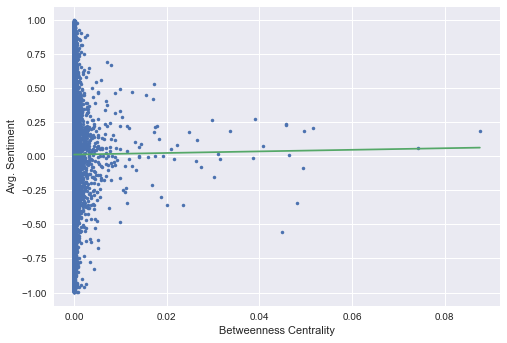

In [25]:
import numpy as np

x = sentiment_analysis.loc[:,"betweenness"].values
y = sentiment_analysis.loc[:,"avg_sentiment"].values

# Least squares polynomial fit
m, b = np.polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')
plt.xlabel("Betweenness Centrality")
plt.ylabel("Avg. Sentiment")
plt.show()

In [26]:
# Compute Pearson correlation coefficient and the p-value for testing non-correlation
import scipy.stats

scipy.stats.pearsonr(x, y)

(0.0031029005006210962, 0.76071969588837507)

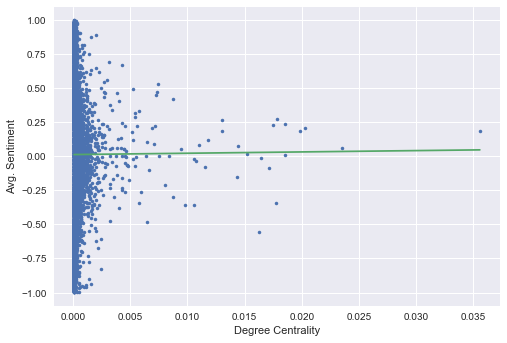

In [27]:
x = sentiment_analysis.loc[:,"degree"].values
y = sentiment_analysis.loc[:,"avg_sentiment"].values

# Least squares polynomial fit
m, b = np.polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')
plt.xlabel("Degree Centrality")
plt.ylabel("Avg. Sentiment")
plt.show()

In [28]:
# Compute Pearson correlation coefficient and the p-value for testing non-correlation
scipy.stats.pearsonr(x, y)

(0.0020811207090573563, 0.838156234943637)